In [1]:
import os
from models.training import *
from data.data_generation import *
from models.models_nn import *
from models.stein import *
from models.pve import *
import torch.optim as optim
from data.data_generation import *
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
def plot_empirical(samples, prior):
    # dataset
    X = samples.detach().numpy().reshape(-1)
    X_plot = np.linspace(min(X), max(X), 1000)
    num_bins = 35
    fig, ax = plt.subplots()
    # the histogram of the data
    n, bins, patches = ax.hist(X, num_bins, density=1)

    ax.set_xlabel('PVE')
    ax.set_ylabel('density')

    kde = gaussian_kde(X)
    kde_pdf = kde.evaluate(X_plot)

    prior_pdf = prior.pdf(torch.tensor(X_plot)).numpy()
    ax.plot(X_plot, kde_pdf)
    ax.plot(X_plot, prior_pdf, 'r-')
    ax.set_title('Empirical distribution of PVE')

    ax.legend(('KDE of empirical PVE', 'Prior PVE', 'Empirical PVE'))

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()

In [3]:
path_data = os.getcwd() + '/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 100; noise_level = 0.8
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_energy(path_data, num_random, noise_level)

### HMF prior with information of PVE and sparsity

### step 1. define prior belief about the number of relevant features

In [4]:
k_min = 0.; k_max = num_useful; tau = np.exp(2);

### step 2. learn the optimal scale parameter to match prior PVE

In [5]:
def learn_optimal_pve():
    alpha_prior = 1.5; beta_prior = 3.0; prior = BetaPrior(alpha_prior, beta_prior)  # prior pve: Beta(1.5,3)
    eta = 0.1; estimator = SteinGradientEstimator(eta)  # define the stein gradient estimator
    learning_rate = 2 * 1e-3;  M = 300 # define learning rate and batch size (M)
    num_hidden_nodes = [50, 30] # define the NN architecture
    sampler = PVESampler_InfoARD(x, M, num_hidden_nodes, k_min, k_max, tau)  # define the sampler of implicity distribution
    samples = sampler()
    plot_empirical(samples, prior)
    parameters = sampler.parameters()
    optimizer = optim.SGD(parameters, lr=learning_rate)
    num_epoch_stein = 200;
    scale = minimize_kldivergence(sampler, prior, optimizer, estimator, num_epoch_stein)
    samples = sampler()
    plot_empirical(samples, prior)
    return scale

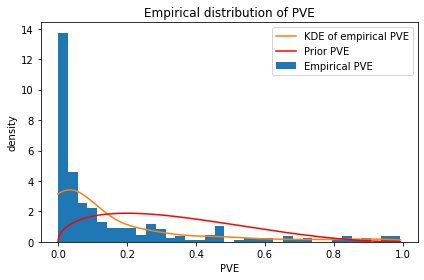

EPOCH 0: KL: -0.1972.
EPOCH 10: KL: -0.1730.
EPOCH 20: KL: 0.1852.
EPOCH 30: KL: 0.0481.
EPOCH 40: KL: 0.2072.
EPOCH 50: KL: -0.0598.
EPOCH 60: KL: 0.0713.
EPOCH 70: KL: 0.2005.
EPOCH 80: KL: 0.0190.
EPOCH 90: KL: 0.3210.
EPOCH 100: KL: 0.3472.
EPOCH 110: KL: 0.2953.
EPOCH 120: KL: -0.0236.
EPOCH 130: KL: 0.2249.
EPOCH 140: KL: -0.1241.
EPOCH 150: KL: 0.3106.
EPOCH 160: KL: 0.2252.
EPOCH 170: KL: -0.0288.
EPOCH 180: KL: 0.0289.
EPOCH 190: KL: 0.1797.


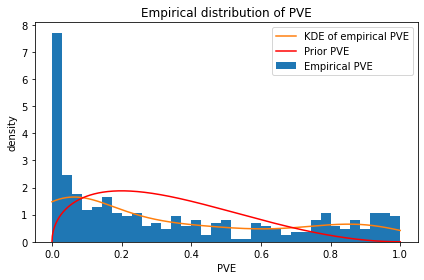

In [6]:
scale = learn_optimal_pve()

In [7]:
print('optimal scale is ' + str(scale))

optimal scale is [0.20501617]


### step 3. train BNNs with information of sparsity and PVE

In [8]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
ihmf = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

EPOACH 1: TRAIN LOSS: 2.0221; KL REG: 19333.1367; TEST LOSS IS: 1.98995.
EPOACH 501: TRAIN LOSS: 0.8895; KL REG: 2207.8635; TEST LOSS IS: 0.83754.
EPOACH 1001: TRAIN LOSS: 0.9442; KL REG: 303.8816; TEST LOSS IS: 0.83004.
EPOACH 1501: TRAIN LOSS: 0.9485; KL REG: 133.2451; TEST LOSS IS: 0.83152.
EPOACH 2001: TRAIN LOSS: 0.9230; KL REG: 78.1566; TEST LOSS IS: 0.79865.
EPOACH 2501: TRAIN LOSS: 0.9170; KL REG: 74.5306; TEST LOSS IS: 0.79009.
EPOACH 3001: TRAIN LOSS: 0.9168; KL REG: 67.6863; TEST LOSS IS: 0.78831.
EPOACH 3501: TRAIN LOSS: 0.9097; KL REG: 79.6688; TEST LOSS IS: 0.77874.
EPOACH 4001: TRAIN LOSS: 0.9103; KL REG: 67.6395; TEST LOSS IS: 0.77950.
EPOACH 4501: TRAIN LOSS: 0.9126; KL REG: 71.8781; TEST LOSS IS: 0.78273.


In [9]:
np.mean(PVE_test_noise(ihmf, x_test, y_test))

0.18652820587158203